# The stochastic optimal growth model with the collocation method + Gaussian quadrature approximation

The purpose of this notebook is to demonstrate how to implement the collocation method for functional approximation and Gaussian quadrature method for the approximation of expectation.

The original set up is based on [the notebook by QuantEcon](https://julia.quantecon.org/dynamic_programming/optgrowth.html).
It uses the linear-interpolation approximation and Monte Carlo approximation.
I contrast these two implementations from the run-time and accuracy perspectives.

After basically completing this notebook, I found that [Julien Pascal has implemented the collocation method to solve the stochastic optimal growth problem](https://julienpascal.github.io/post/collocation/).
Our analyses largely overlap but I hope I am providing some new insights here (eg. implementing the collocation method with the `ApproxFun` package).

## The model

Consider an agent with an amount $y_t$ of a consumption good at period $t$.
This can be used for productive investment or consumption.

With a production shock, $\xi_t$, the next period output is

$$
    y_{t + 1} = f(k_{t + 1}) \xi_{t + 1},
$$

where $f$ is the production function.

The resource constraint is 

$$
    k_{t + 1} + c_t \le y_t.
$$

For more details on the set up, refer to [the original notebook](https://julia.quantecon.org/dynamic_programming/optgrowth.html).

## Optimization

Taking $y_0$ as given, the agent maximizes
$$
    E \left[ \sum_{t = 0}^{\infty} \beta^t u(c_t) \right]
$$

subject to 

$$
    y_{t + 1} = f(y_t - c_t) \xi_{t + 1} \quad \forall t \\
    0 \le c_t \le y_t \quad \forall t.
$$

The Bellman equation takes the form

$$
    w(y) = \max_{0 \le c \le y} \left\{ u(c) + \beta E\left[w \left( f(y - c) \xi \right) \right] \right\}.
$$

## Computation

In [1]:
using LinearAlgebra, Statistics
using LaTeXStrings, Plots, QuantEcon, Interpolations, ApproxFun
using Optim, Random, Parameters
using BenchmarkTools, NLsolve

For the functional forms, it is assumed that

- utility function: $u(c) = log(c)$
- production function: $f(k; \alpha) = k^{\alpha}$

In [2]:
Random.seed!(42)
u(c; p) = log(c)
f(k; p) = k^p.α

f (generic function with 1 method)

The production shock is assumed to follow the log-normal distribution.
The parametric assumptions are defined here.
Also, note that, because the analytical solution for the value function is known, it is implemented here as well.

In [3]:
OptimalGrowthModel = @with_kw (
    α = 0.4, β = 0.96, μ = 0.0, s = 0.1, 
    u = u, f = f,
    S = Chebyshev(1e-5..4.0),
    y = points(S, 50) # Note that this grid is sorted in the reverse order
)
p = OptimalGrowthModel();

function v_star(y; p)
    @unpack α, μ, β = p
    c1 = log(1. - α * β) / (1. - β)
    c2 = (μ + α * log(α * β)) / (1. - α)
    c3 = 1. / (1. - β)
    c4 = 1. / (1. - α * β)
    return c1 + c2 * (c3 - c4) + c4 * log(y)
end
c_star(y; p) = (1 - p.α * p.β) * y;

## Computation (Collocation method + Gaussian quadrature approximation)

Here, I solve the Bellman equation by approximating the value function with the collocation.
For this, refer to, for example, [the textbook by Miranda and Fackler](https://mitpress.mit.edu/9780262633093/applied-computational-economics-and-finance/).

I approximate $w(y)$ by $\sum_{j = 1}^n h_j \phi_j(y)$.
Using this, the Bellman equation above is approximated by

$$
    w(y) \approx \max_{0 \le c \le y} \left\{ u(c) + \beta E\left[\sum_{j = 1}^n h_j \phi_j \left( f(y - c) \xi \right) \right] \right\},
$$

where $h_j$ is a colloation coefficient at a collocation node $j$.


Furthermore, I approximate the expectation with the Gaussian quadrature method:

$$
    w(y) \approx \max_{0 \le c \le y} \left\{ u(c) + \beta \sum_{k = 1}^K \tau_k \left[\sum_{j = 1}^n h_j \phi_j \left( f(y - c) \xi_k \right) \right] \right\},
$$

where $\tau_k$ is a Gaussian quadrature weight.

In [4]:
ξ_nodes, ξ_weights = qnwlogn(10, p.μ, p.s);

In [5]:
# Bellman Operator with a collocation method
function T(w; p, tol = 1e-10)
    @unpack β, u, f, S, y = p
    fapprox = Fun(S, ApproxFun.transform(S, w));

    Tw = similar(w)
    σ = similar(w)
    for (i, y_val) in enumerate(y)
        results = Optim.optimize(
            c -> -(u(c; p=p) + β * dot(fapprox.(f(y_val - c; p=p) .* ξ_nodes), ξ_weights)),
            1e-10, 
            y_val - 1e-10
        )
        Tw[i] = -Optim.minimum(results)
        σ[i] = Optim.minimizer(results)
    end
    return (; w = Tw, σ = σ)
end

T (generic function with 1 method)

In [6]:
function solve_optgrowth(initial_w; p, iterations = 500, m = 2, show_trace = false)
    results = fixedpoint(x -> T(x; p=p).w, initial_w, iterations=iterations, m=m, show_trace=show_trace);
    v_star = results.zero;
    σ = T(results.zero; p=p).σ;
    return (;v_star=v_star, σ=σ, results=results)
end

solve_optgrowth (generic function with 1 method)

In [7]:
initial_w = 5 * log.(p.y);
sol = solve_optgrowth(initial_w; p=p);
v_star_approx = sol.v_star;
println("Converted in $(sol.results.iterations) to an ||residuals||_∞ of $(sol.results.residual_norm)")

Converted in 17 to an ||residuals||_∞ of 2.3554420636173745e-9


In [8]:
fapprox = Fun(p.S, ApproxFun.transform(p.S, v_star_approx));

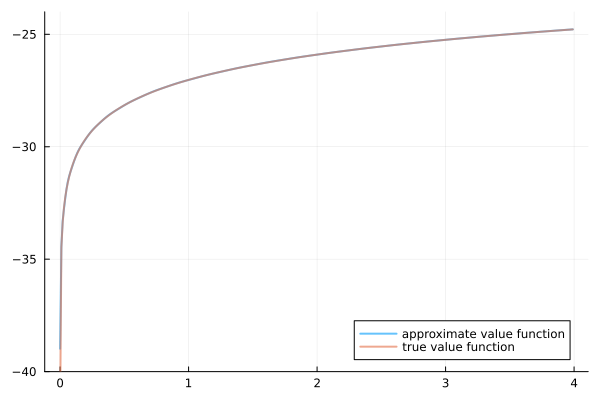

In [9]:
y_range = 1e-4:0.01:4.0;

plt = plot(ylim = (-40, -24), fmt = :png)
plot!(plt, y_range, fapprox.(y_range), linewidth = 2, alpha = 0.6, label = "approximate value function")
plot!(plt, y_range, v_star.(y_range; p=p), linewidth = 2, alpha = 0.6, label = "true value function")
plot!(plt, legend = :bottomright)

## Computation (original: Interpolation approximation + Monte Carlo approximation)

The original notebook used the interpolation approximation for the function $w$ and also Monte Carlo approximation for the expectation.

In [10]:
OptimalGrowthModel_orig = @with_kw (
    α = 0.4, β = 0.96, μ = 0.0, s = 0.1, 
    u = u, f = f,
    y = range(1e-5, 4.0, length = 200)
)
p_orig = OptimalGrowthModel_orig();

In [11]:
# Bellman Operator in the original implementation
function T_orig(w; p, tol = 1e-10)
    @unpack β, u, f, y = p
    w_func = linear_interpolation(y, w, extrapolation_bc = Interpolations.Line());
    
    Tw = similar(w);
    σ = similar(w);
    for (i, y_val) in enumerate(y)
        results = Optim.optimize(
            c -> -(u(c; p=p) + β * dot(w_func.(f(y_val - c; p=p) .* ξ_nodes), ξ_weights)), 
            1e-10, 
            y_val - 1e-10
        );
        Tw[i] = -Optim.minimum(results);
        σ[i] = Optim.minimizer(results);
    end
    return (; w = Tw, σ = σ)
end

T_orig (generic function with 1 method)

In [12]:
function solve_optgrowth_orig(initial_w; p, iterations = 500, m = 3, show_trace = false)
    results = fixedpoint(x -> T_orig(x; p=p).w, initial_w, iterations=iterations, m=m, show_trace=show_trace);
    v_star = results.zero
    σ = T_orig(results.zero; p=p).σ
    return (;v_star=v_star, σ=σ, results=results)
end

solve_optgrowth_orig (generic function with 1 method)

In [13]:
initial_w = 5 * log.(p_orig.y)
sol = solve_optgrowth_orig(initial_w; p=p_orig)
v_star_approx = sol.v_star
println("Converted in $(sol.results.iterations) to an ||residuals||_∞ of $(sol.results.residual_norm)")

Converted in 17 to an ||residuals||_∞ of 4.72675765195163e-9


In [14]:
w_func = linear_interpolation(p_orig.y, v_star_approx, extrapolation_bc = Interpolations.Line());

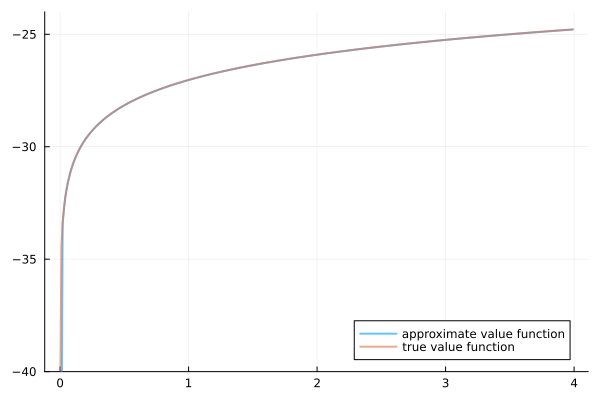

In [15]:
y_range = 1e-4:0.01:4.0;

plt = plot(ylim = (-40, -24), fmt = :png)
plot!(plt, y_range, w_func(y_range), linewidth = 2, alpha = 0.6, label = "approximate value function")
plot!(plt, y_range, v_star.(y_range; p=p), linewidth = 2, alpha = 0.6, label = "true value function")
plot!(plt, legend = :bottomright)


## Run-time comparision

In [16]:
@benchmark solve_optgrowth(5 * log.(p.y); p=p)

BenchmarkTools.Trial: 218 samples with 1 evaluation.
 Range (min … max):  22.285 ms …  27.637 ms  ┊ GC (min … max): 0.00% … 9.87%
 Time  (median):     22.647 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   22.984 ms ± 728.256 μs  ┊ GC (mean ± σ):  1.76% ± 2.55%

   █▅                                  ▂                        
  ▅██▆▃▆▃▄▇█▆▃▃▂▃▃▃▁▃▁▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▆▇█▄▅▃▄▃▂▃▂▁▁▃▁▁▁▂▁▂▁▂▂▂▂ ▃
  22.3 ms         Histogram: frequency by time         24.6 ms <

 Memory estimate: 13.66 MiB, allocs estimate: 635682.

In [17]:
@benchmark solve_optgrowth_orig(5 * log.(p_orig.y); p=p_orig)

BenchmarkTools.Trial: 48 samples with 1 evaluation.
 Range (min … max):   99.502 ms … 133.845 ms  ┊ GC (min … max): 1.61% … 3.74%
 Time  (median):     102.780 ms               ┊ GC (median):    3.29%
 Time  (mean ± σ):   104.345 ms ±   5.809 ms  ┊ GC (mean ± σ):  3.08% ± 0.66%

     █▆██  ▂                                                     
  ▆▁██████▁██▁▄▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  99.5 ms          Histogram: frequency by time          134 ms <

 Memory estimate: 79.98 MiB, allocs estimate: 3338431.

## Brief discussions

1. Looking at the run time, it seems collocation method is ~4X faster. If I use the [`CompEcon` package](https://github.com/QuantEcon/CompEcon.jl) instead of the `ApproxFun` package, actually the collocation method is slower. This is consistent with [the finding in the experiment by Julien Pascal](https://julienpascal.github.io/post/collocation/). 
2. While the collocation method leads to a decent approximation even when $y$ is close to 0, the approximation is poor for small $y$ in the original implementation with linear interpolations. See the figure below. This could be related to how the values are "extrapolated" outside the grids in the interpolation method.

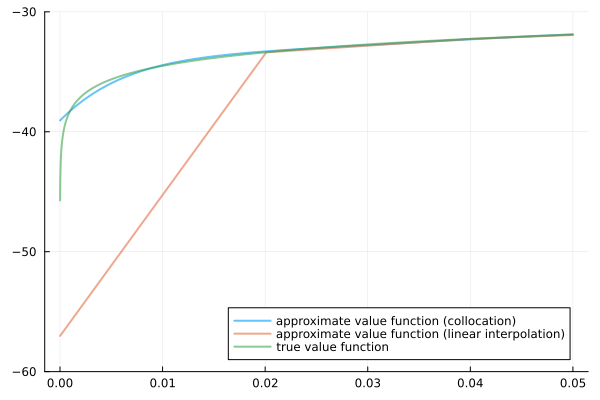

In [18]:
y_range = 1e-5:2e-5:5e-2;

plt = plot(ylim = (-60, -30), fmt = :png)
plot!(plt, y_range, fapprox.(y_range), linewidth = 2, alpha = 0.6, label = "approximate value function (collocation)")
plot!(plt, y_range, w_func(y_range), linewidth = 2, alpha = 0.6, label = "approximate value function (linear interpolation)")
plot!(plt, y_range, v_star.(y_range; p=p), linewidth = 2, alpha = 0.6, label = "true value function")
plot!(plt, legend = :bottomright)